In [25]:
def loadDataSet():
    postingList = [
        ["my", "dog", "has", "flea", "problems", "help", "please"],
        ["maybe", "not", "take", "him", "to", "dog", "park", "stupid"],
        ["my", "dalmation", "is", "so", "cute", "I", "love", "him"],
        ["stop", "posting", "stupid", "worthless", "garbage"],
        ["mr", "licks", "ate", "my", "steak", "how", "to", "stop", "him"],
        ["quit", "buying", "worthless", "dog", "food", "stupid"]
    ]
    classVec = [0, 1, 0, 1, 0, 1]
    return postingList, classVec

'''
合并集合
'''
def createVocabList(dataSet):
    vocabSet = set([])
    for document in dataSet:
        vocabSet = vocabSet | set(document)  #求并
    return list(vocabSet)

'''
检查词汇表的单词是否在输入文档中出现，
词集模型
'''
def setOfWords2Vec(vocabList, inputSet):
    returnVec = [0]*len(vocabList)
    for word in inputSet:
        if word in vocabList:
            returnVec[vocabList.index(word)] = 1
        else:
            print("the word: %s is not in my Vocabulary!" % word)
    return returnVec


'''
检查词汇表的单词是否在输入文档中出现的次数
词袋模型
'''
def bagOfWords2Vec(vocabList, inputSet):
    returnVec = [0]*len(vocabList)
    for word in inputSet:
        if word in vocabList:
            returnVec[vocabList.index(word)] += 1
        else:
            print("the word: %s is not in my Vocabulary!" % word)
    return returnVec

listOPosts, listClasses = loadDataSet()
myVocabList= createVocabList(listOPosts)
# xx = setOfWords2Vec(myVocabList, listOPosts[0])
# # xx

In [26]:
from numpy import *

def trainNB0(trainMatrix, trainCategory):
    numTrainDocs = len(trainMatrix)
    numWords = len(trainMatrix[0])
    '''
        类别向量中 1-侮辱，0-非侮辱
        可以直接累加向量中的值，除以总数获取 侮辱的概率
        如果不是1或0，需要单独累加计算
    '''
    pAbusive = sum(trainCategory)/float(numTrainDocs)

    '''
    利用bayes计算多个概率的乘积以获得文档属于某个类别的概率
    即p(w0|y)*p(w1|y)*p(w2|y)....  如果其中一个概率为0，则最后
    的乘积也为0，与实际不符，为了消除影响，采用拉普拉斯修正，
    分子加1，分母加N 其中N为类别数， 
    当样本数越来越大时，这种修正的影响会越来越小
    所以原，要改为：
    p0Num = zeros(numWords)
    p1Num = zeros(numWords)
    p0Denom = 0.0
    p1Denom = 0.0
    '''
    p0Num = ones(numWords)
    p1Num = ones(numWords)
    p0Denom = 2.0
    p1Denom = 2.0
    
    '''
    如果多分类，增加if else 判断即可，这里只有1和0 
    '''
    for i in range(numTrainDocs):
        if trainCategory[i] == 1:
            p1Num += trainMatrix[i]
            p1Denom += sum(trainMatrix[i]) #类别为1时，所有特征值的个数
        else:
            p0Num += trainMatrix[i]
            p0Denom += sum(trainMatrix[i]) #类别为0时，所有特征值的个数   
#         print(p1Num)
#         print(p0Num)
#         print("p1Denom %f" % p1Denom)
#         print("p0Denom %f" % p0Denom)
    '''
        大部分乘积因子都很小，相乘是很小的数，程序会向下溢出
        多数相乘，不好求解，采用自然对数处理不会有任何损失，
        f(x)与lnf(x）的曲线，检查者两条曲线，曲线变化和取极值都相同
    '''
    p1Vect = log(p1Num/p1Denom)
    p0Vect = log(p0Num/p0Denom)
    return p0Vect, p1Vect, pAbusive

In [27]:
trainMat = []
for postinDoc in listOPosts:
    trainMat.append(setOfWords2Vec(myVocabList, postinDoc))
# type(trainMat)

p0Vect, p1Vect, pAbusive = trainNB0(trainMat, listClasses)
p1Vect

array([-3.04452244, -2.35137526, -2.35137526, -3.04452244, -3.04452244,
       -2.35137526, -3.04452244, -2.35137526, -3.04452244, -2.35137526,
       -3.04452244, -2.35137526, -3.04452244, -3.04452244, -1.94591015,
       -2.35137526, -2.35137526, -3.04452244, -3.04452244, -3.04452244,
       -1.65822808, -2.35137526, -3.04452244, -3.04452244, -3.04452244,
       -2.35137526, -3.04452244, -2.35137526, -2.35137526, -3.04452244,
       -3.04452244, -1.94591015])

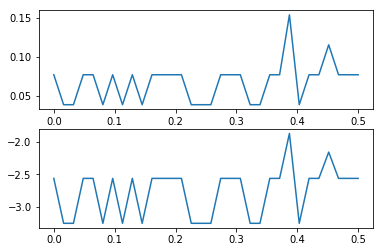

In [28]:
'''
画出 p0Vect取对数前后的图形
从图中可以看出，两种曲线变化趋势是一样的，
且都在同一处取得最大极值
'''

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

zhfont1 = matplotlib.font_manager.FontProperties(fname="../SimHei.ttf") 

x = linspace(0,0.5,32)
fig = plt.figure()
p0 = fig.add_subplot(2,1,1)
p0.plot(x, exp(p0Vect))
p1 = fig.add_subplot(2,1,2)
p1.plot(x, p0Vect)
plt.show()

In [29]:
from numpy import *

'''
bayes分类函数
朴素贝叶斯分类函数
vec2Classify:待测试分类的词条向量
p0Vec:类别0所有文档中各个词条出现的频数p(wi|c0)
p0Vec:类别1所有文档中各个词条出现的频数p(wi|c1)
pClass1:类别为1的文档占文档总数比例
'''
def classifyNB(vec2Classify, p0Vec, p1Vec, pClass1):
    '''
    求得给定P(y|x)的概率
    实际计算公式应该是sum(vec2Classify*p1Vec)*pClass1，为计算方便对该值去log
    但是考虑到sum(vec2Classify*p1Vec)值可能有为0的项，那么取log没有意义，
    因此sum(vec2Classify*p1Vec)不取对数，但这样处理不影响结果的判断
    '''
    p1 = sum(vec2Classify*p1Vec) + log(pClass1)
    p0 = sum(vec2Classify*p0Vec) + log(1-pClass1)
    if p1 > p0:
        return 1
    else:
        return 0

def testingNB():
    #下面的代码上面执行过，jupyter会保留这个变量，这里我们屏蔽
    #读者参考时，记得写上
#     listOposts, listClasses = loadDataSet()
#     myVocabList = createVocabList(listOposts)
#     trainMat = []
#     for postinDoc in listOPosts:
#         trainMat.append(setOfWords2Vec(myVocabList, postinDoc))
#     p0Vect, p1Vect, pAbusive = trainNB0(trainMat, listClasses)
    testEntry = ["love", "my", "dalmation"]
    thisDoc = array(setOfWords2Vec(myVocabList, testEntry))
    print("testEntry, classified as:", classifyNB(thisDoc, p0Vect, p1Vect, pAbusive) )

    testEntry1 = ["stupid", "garbage"]
    thisDoc1 = array(setOfWords2Vec(myVocabList, testEntry1))
    print("testEntry, classified as:", classifyNB(thisDoc1, p0Vect, p1Vect, pAbusive) )

testingNB()

testEntry, classified as: 0
testEntry, classified as: 1


In [30]:
# -*- coding: utf8 -*-

def text_parse(bigString):
    import re
    listOfTokens = re.split(r'\W*', bigString)
    return [tok.lower() for tok in listOfTokens if len(tok) > 2]

def spam_test():
    docList = []
    classList = []
    fullText = []
    # email中有25个文件
    for i in range(1, 26):
        #byte.decode() byte to str
#         wordList = text_parse(open("email/spam/%d.txt" % i, "rb").read().decode())
        wordList = text_parse(open("email/spam/%d.txt" % i).read())
        docList.append(wordList)
        fullText.extend(wordList)
        classList.append(1)
        wordList = text_parse(open("email/spam/%d.txt" % i).read())
        docList.append(wordList)
        fullText.extend(wordList)
        classList.append(0)
    vocabList = createVocabList(docList)
    trainingSet = list(range(50))
    testSet=[]
    for i in range(10):#随机抽取10个
        randIndex = int(random.uniform(0, len(trainingSet)))
        testSet.append(trainingSet[randIndex])
        del(trainingSet[randIndex])
    trainMat = []
    trainClasses = []
    for docIndex in trainingSet:
        trainMat.append(setOfWords2Vec(vocabList, docList[docIndex]))
        trainClasses.append(classList[docIndex])
    p0V, p1V, pSpam = trainNB0(array(trainMat), array(trainClasses))
    
    #测试错误率
    errorCount =0
    for docIndex in testSet:
        wordVector = setOfWords2Vec(vocabList, docList[docIndex])
        if classifyNB(array(wordVector), p0V, p1V, pSpam) != classList[docIndex]:
            errorCount += 1
    rate = float(errorCount)/len(testSet)
    print("the error rate is : ", rate)
    return rate

s = 0.0
for i in range(10):
    s += spam_test()
s = s/10.0
s

# spam_test()
# i = 1
# wordList= text_parse(open("email/spam/%d.txt" % i).read())
# wordList

the error rate is :  0.6
the error rate is :  0.5
the error rate is :  0.6
the error rate is :  0.6
the error rate is :  0.6
the error rate is :  0.5
the error rate is :  0.6
the error rate is :  0.7
the error rate is :  0.7
the error rate is :  0.7


0.6100000000000001

In [48]:
import numpy as np

'''
为了便于扩展，创建简单的通用bayes训练类,
各种分类函数，继承覆写其具体的分类函数
将前面的代码简单汇总即可
'''
class Bayes():
    
    def __init__(self, data_list, class_vec):
        self.data_list = data_list
        self.class_vec = class_vec
        self.vocabList = []

#     def loadDataSet(self):
#         postingList = self.data_list
#         classVec = slef.class_vec
#         return postingList, classVec
    def set_class_vec(self, class_vec):
        self.class_vec = class_vec    

    def get_vocab_list(self):
        return self.vocabList

    def get_bays_item(self):
        return self.p0Vect, self.p1Vect, self.pAbusive        

    '''
    合并集合
    '''
    def createVocabList(self):
        dataSet = self.data_list
        vocabSet = set([])
        for document in dataSet:
            vocabSet = vocabSet | set(document)  #求并
        self.vocabList = list(vocabSet)
        return self.vocabList

    '''
    检查词汇表的单词是否在输入文档中出现，
    词集模型
    '''
    def setOfWords2Vec(self, inputSet):
        vocabList = self.vocabList
        returnVec = [0]*len(vocabList)
        for word in inputSet:
            if word in vocabList:
                returnVec[vocabList.index(word)] = 1
            else:
                print("the word: %s is not in my Vocabulary!" % word)
#         self.returnVec = returnVec
        return returnVec

    '''
    检查词汇表的单词是否在输入文档中出现的次数
    词袋模型
    '''
    def bagOfWords2Vec(self, inputSet):
        vocabList = self.vocabList
        returnVec = [0]*len(vocabList)
        for word in inputSet:
            if word in vocabList:
                returnVec[vocabList.index(word)] += 1
            else:
                print("the word: %s is not in my Vocabulary!" % word)
#         self.returnVec = returnVec
        return returnVec

    def trainNB0(self, trainMatrix, trainCategory = None):
        if type(trainCategory) == None: #没有值则选择所有类别
            trainCategory = self.class_vec        
            
        numTrainDocs = len(trainMatrix)
        numWords = len(trainMatrix[0])
        '''
            类别向量中 1-侮辱，0-非侮辱
            可以直接累加向量中的值，除以总数获取 侮辱的概率
            如果不是1或0，需要单独累加计算
        '''
        pAbusive = sum(trainCategory)/float(numTrainDocs)

        '''
        利用bayes计算多个概率的乘积以获得文档属于某个类别的概率
        即p(w0|y)*p(w1|y)*p(w2|y)....  如果其中一个概率为0，则最后
        的乘积也为0，与实际不符，为了消除影响，采用拉普拉斯修正，
        分子加1，分母加N 其中N为类别数， 
        当样本数越来越大时，这种修正的影响会越来越小
        所以原，要改为：
        p0Num = np.zeros(numWords)
        p1Num = np.zeros(numWords)
        p0Denom = 0.0
        p1Denom = 0.0
        '''
        p0Num = np.ones(numWords)
        p1Num = np.ones(numWords)
        p0Denom = 2.0
        p1Denom = 2.0

        '''
        如果多分类，增加if else 判断即可，这里只有1和0 
        '''
        for i in range(numTrainDocs):
            if trainCategory[i] == 1:
                p1Num += trainMatrix[i]
                p1Denom += sum(trainMatrix[i]) #类别为1时，所有特征值的个数
            else:
                p0Num += trainMatrix[i]
                p0Denom += sum(trainMatrix[i]) #类别为0时，所有特征值的个数   
    #         print(p1Num)
    #         print(p0Num)
    #         print("p1Denom %f" % p1Denom)
    #         print("p0Denom %f" % p0Denom)
        '''
            大部分乘积因子都很小，相乘是很小的数，程序会向下溢出
            多数相乘，不好求解，采用自然对数处理不会有任何损失，
            f(x)与lnf(x）的曲线，检查者两条曲线，曲线变化和取极值都相同
        '''
        p1Vect = log(p1Num/p1Denom)
        p0Vect = log(p0Num/p0Denom)
        
        self.p0Vect = p0Vect
        self.p1Vect = p1Vect     
        self.pAbusive = pAbusive
#         return p0Vect, p1Vect, pAbusive


    '''
    bayes分类函数
    朴素贝叶斯分类函数
    vec2Classify:待测试分类的词条向量
    p0Vec:类别0所有文档中各个词条出现的频数p(wi|c0)
    p0Vec:类别1所有文档中各个词条出现的频数p(wi|c1)
    pClass1:类别为1的文档占文档总数比例
    '''
    def classifyNB(self, vec2Classify):
        p0Vec = self.p0Vect
        p1Vec = self.p1Vect
        pClass1 = self.pAbusive

        '''
        求得给定P(y|x)的概率
        实际计算公式应该是sum(vec2Classify*p1Vec)*pClass1，为计算方便对该值去log
        但是考虑到sum(vec2Classify*p1Vec)值可能有为0的项，那么取log没有意义，
        因此sum(vec2Classify*p1Vec)不取对数，但这样处理不影响结果的判断
    
        '''
        p1 = sum(vec2Classify*p1Vec) + log(pClass1)
        p0 = sum(vec2Classify*p0Vec) + log(1-pClass1)
        if p1 > p0:
            return 1
        else:
            return 0

# 识别侮辱性文档
def testingNB(listOposts, listClasses):
    bayes = Bayes(listOposts, listClasses)
    bayes.createVocabList()
    trainMat = []
    for postinDoc in listOPosts:
        trainMat.append(bayes.setOfWords2Vec(postinDoc))
    bayes.trainNB0(trainMat)
    testEntry = ["love", "my", "dalmation"]
    thisDoc = np.array(bayes.setOfWords2Vec(testEntry))
    print("testEntry, classified as:", bayes.classifyNB(thisDoc) )

    testEntry1 = ["stupid", "garbage"]
    thisDoc1 = np.array(bayes.setOfWords2Vec(testEntry1))
    print("testEntry, classified as:", bayes.classifyNB(thisDoc1) )

postingList = [
    ["my", "dog", "has", "flea", "problems", "help", "please"],
    ["maybe", "not", "take", "him", "to", "dog", "park", "stupid"],
    ["my", "dalmation", "is", "so", "cute", "I", "love", "him"],
    ["stop", "posting", "stupid", "worthless", "garbage"],
    ["mr", "licks", "ate", "my", "steak", "how", "to", "stop", "him"],
    ["quit", "buying", "worthless", "dog", "food", "stupid"]
]
# classVec = [0, 1, 0, 1, 0, 1]  #0-非侮辱性 1-侮辱性
# testingNB(postingList, classVec)

In [32]:
'''
# 识别垃圾邮件
'''
#词汇解析
def text_parse(bigString):
    import re
    listOfTokens = re.split(r'\W*', bigString)
    return [tok.lower() for tok in listOfTokens if len(tok) > 2]

def spam_test():
    import numpy as np
    
    docList = []
    classList = []
    fullText = []
    # email中有25个文件
    for i in range(1, 26):
        #byte.decode() byte to str
#         wordList = text_parse(open("email/spam/%d.txt" % i, "rb").read().decode())
        wordList = text_parse(open("email/spam/%d.txt" % i).read())
        docList.append(wordList)
        fullText.extend(wordList)
        classList.append(1)
        wordList = text_parse(open("email/spam/%d.txt" % i).read())
        docList.append(wordList)
        fullText.extend(wordList)
        classList.append(0)

    bayes = Bayes(docList, classList)
    bayes.createVocabList()
#     vocabList = createVocabList(docList)
    trainingSet = list(range(50))
    testSet=[]
    for i in range(10):#随机抽取10个
        randIndex = int(random.uniform(0, len(trainingSet)))
        testSet.append(trainingSet[randIndex])
        del(trainingSet[randIndex])
    trainMat = []
    trainClasses = []
    for docIndex in trainingSet:
        trainMat.append(bayes.setOfWords2Vec(docList[docIndex]))
        trainClasses.append(classList[docIndex])
    bayes.set_class_vec(trainClasses)
    bayes.trainNB0(np.array(trainMat))
    
    #测试错误率
    errorCount =0
    for docIndex in testSet:
        wordVector = bayes.setOfWords2Vec(docList[docIndex])
        if bayes.classifyNB(np.array(wordVector)) != classList[docIndex]:
            errorCount += 1
    rate = float(errorCount)/len(testSet)
    print("the error rate is : ", rate)
    return rate

s = 0.0
for i in range(10):
    s += spam_test()
s = s/10.0
s

the error rate is :  0.6
the error rate is :  0.6
the error rate is :  0.6
the error rate is :  0.6
the error rate is :  0.5
the error rate is :  0.8
the error rate is :  0.6
the error rate is :  0.6
the error rate is :  0.6
the error rate is :  0.6


0.6099999999999999

In [71]:
'''
Rss源分类及高频词去除函数
'''

import feedparser
import operator

'''
修改后的分词函数
'''
def text_parse(bigString):
    import re
    listOfTokens = re.split(r'\W+', bigString)
    return [tok.lower() for tok in listOfTokens if len(tok) > 2]

def calc_most_freq(vocab_list, full_text):
    print(vocab_list)
    freq_dict = {}
    '''
    计算词汇出现频率
    '''
    for token in vocab_list:
        freq_dict[token] = full_text.count(token)
    sorted_freq = sorted(freq_dict.iteritems(), key=operator.itemgetter(1), reverse = True)
    return sorted_freq(30)

'''
分类函数测试
'''
def borad_test(feed1, feed0):
    doc_list = []
    class_list = []
    full_text = []
    min_len = min(len(feed1["entries"]), len(feed0["entries"]))
    for i in range(min_len):
        word_list = text_parse(feed1["entries"][i]["summary"])
        doc_list.append(word_list)
        full_text.extend(word_list)
        class_list.append(1)

        word_list = text_parse(feed0["entries"][i]["summary"])
        doc_list.append(word_list)
        full_text.extend(word_list)
        class_list.append(0)        
    
    bayes = Bayes(doc_list, class_list)
    bayes.createVocabList()
    
    '''
    找的rss源不到100个 屏蔽下面4行代码
    '''
#     top30_words = calc_most_freq(bayes.get_vocab_list(), full_text)
#     for pair_w in top30_words:
#         if pair_w[0] in vocab_list:
#             vocab_list.remove(pair_w[0])
    training_set = list(range(2*min_len))
    test_set = []
    for i in range(20):
        randIndex = int(random.uniform(0, len(training_set)))
        test_set.append(training_set[randIndex])
        del(training_set[randIndex])
    train_mt = []
    train_classes = []
    for docIndex in training_set:
        train_mt.append(bayes.bagOfWords2Vec(doc_list[docIndex]))
        train_classes.append(class_list[docIndex])
    bayes.trainNB0(np.array(train_mt), np.array(train_classes))
    errorCount = 0
    for docIndex in test_set:
        word_vector = bayes.bagOfWords2Vec(doc_list[docIndex])
        if bayes.classifyNB(np.array(word_vector)) != class_list[docIndex]:
            errorCount += 1
    print("the erroe rate is ", float(errorCount)/len(test_set))
    return bayes.get_vocab_list(), bayes.get_bays_item()

# ny = feedparser.parse("http://newyork.craigslist.org/stp/index.rss")
# sf = feedparser.parse("http://sfbay.craigslist.org/stp/index.rss")
ny = feedparser.parse("https://www.craigslist.org/about/best/nyc/index25.rss")
sf = feedparser.parse("https://www.craigslist.org/about/best/sfo/index25.rss")

In [73]:

# borad_test(ny, sf)

def get_top_word(ny, sf):
    vocab_list, p = borad_test(ny, sf)
    p0V = p[0]
    p1V= p[1]
    topNY = []
    topSF = []
    for i in range(len(p0V)):
        if p0V[i] > -6.0 : topSF.append((vocab_list[i], p0V[i]))
        if p1V[i] > -6.0 : topNY.append((vocab_list[i], p1V[i]))
    sortedSF = sorted(topSF, key=lambda pair: pair[1], reverse=True)
    print(sortedSF)
    print()
    for item in sortedSF:
        print (item[0])
    sortedNY = sorted(topNY, key=lambda pair: pair[1], reverse=True)
    print(sortedNY)
    print() 
    for item in sortedNY:
        print (item[0])

get_top_word(ny, sf)

the erroe rate is  0.2
[('and', -3.2944940431894176), ('the', -3.3854658213951443), ('you', -3.64703674984324), ('jpg', -4.178696460512072), ('for', -4.232763681782348), ('this', -4.270504009765196), ('with', -4.46054761265306), ('that', -4.508175661642315), ('4253939458', -4.584161568620237), ('not', -4.610829815702398), ('was', -4.666399666857209), ('one', -4.8895432181714185), ('will', -4.925910862342294), ('div', -5.002871903478422), ('img', -5.130705274988307), ('alt', -5.130705274988307), ('src', -5.130705274988307), ('image', -5.177225290623199), ('your', -5.177225290623199), ('have', -5.177225290623199), ('are', -5.226015454792631), ('want', -5.226015454792631), ('other', -5.2773087491801824), ('like', -5.2773087491801824), ('href', -5.331375970450457), ('about', -5.331375970450457), ('title', -5.331375970450457), ('all', -5.331375970450457), ('sculpture', -5.331375970450457), ('from', -5.3885343842904065), ('http', -5.449159006106841), ('but', -5.449159006106841), ('fucking', 

25